# Vision pipeline

Includes:
- Calibrating the image from the camera
- Detecting the robot pose (position and orientation)
- Detecting the goal position
- Detecting obstacles

## 1. Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import cv2
import numpy as np
from src import vision

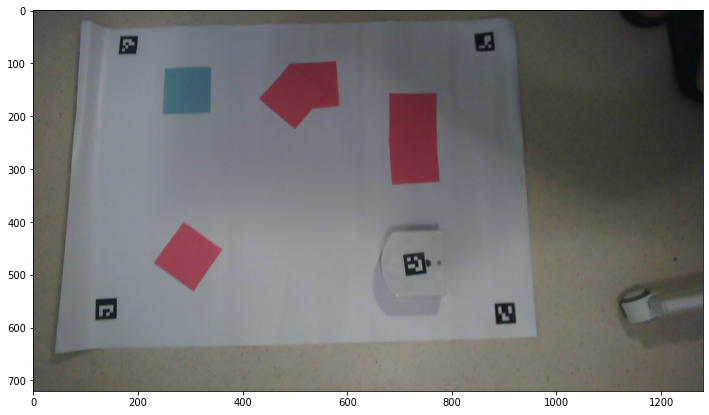

In [2]:
# Load test image
IMG_FILE = '../data/test-img1.jpg'
img = cv2.imread(IMG_FILE)

# Helper function to show image in notebook
def show(img):
    # Matplotlib uses RGB format
    plt.figure(figsize=(12, 7))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb, aspect='auto')
    plt.show()

show(img)

The vision pipeline uses aruco markers.
For clarification, we retrieve them here and display their ID.

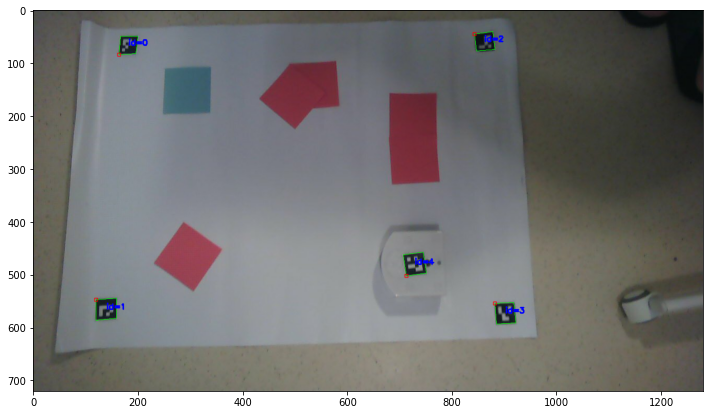

In [3]:
def display_aruco_markers(img):
    markers = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    corners, ids, _ = cv2.aruco.detectMarkers(img, markers)

    result = img.copy()
    cv2.aruco.drawDetectedMarkers(result, corners, ids)
    show(result)

display_aruco_markers(img)

In [4]:
# Helper function for drawing pose
def draw_pose(img, pose):
    # Convert to array for drawing
    position = np.int32([pose.position.x, pose.position.y])

    # Compute direction vector for drawing
    alpha = pose.angle
    direction_vector = np.array([-np.sin(-alpha), np.cos(-alpha)])

    # Draw a circle at the detected position
    result = img.copy()
    cv2.circle(result, position, 4, color=(0, 255, 255), thickness=8)
    cv2.arrowedLine(result, position, position + np.int32(100 * direction_vector), (0, 0, 255), 2)
    show(result)

# Helper function to draw centroids
def draw_centroids(img, centroids):
    result = img.copy()
    for centroid in centroids:
        cv2.circle(result, np.int32(centroid), 4, color=(0, 255, 0), thickness=2)
    show(result)

## 2. Calibration

To callibrate the image, we use the 4 aruco markers in the corners as reference and warp the image to these corners.

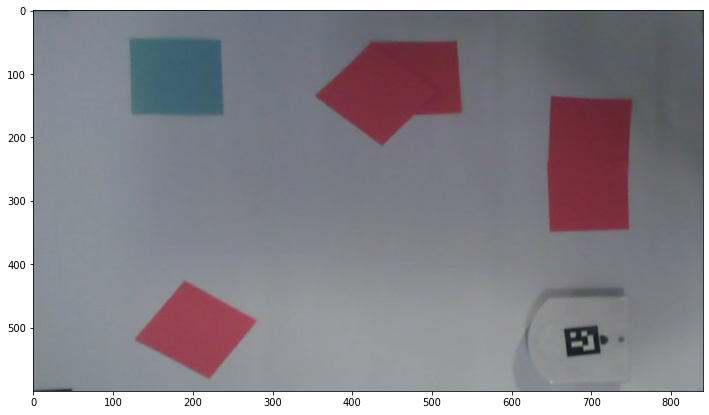

In [5]:
corners_by_id = vision.get_aruco_dict(img)
calibrated = vision.get_warped_image(img, corners_by_id)
show(calibrated)

## 3. Robot pose estimation

We can now retrieve the aruco marker from the thymio.

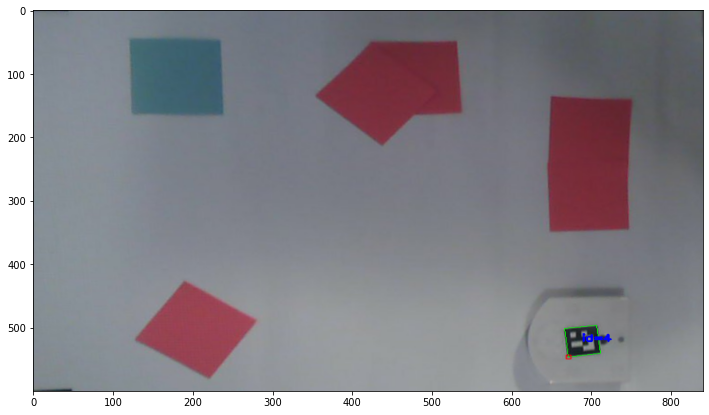

In [6]:
display_aruco_markers(calibrated)
markers = vision.get_aruco_dict(calibrated)
thymio_marker = markers[4] # Has ID 4

Retrieving position is trivial.
Take two corners from the aruco marker, and use the middle point as position for the Thymio.
This does require that the aruco is perfectly centered.
For the angle we use the vector from the bottom right to the top left corner of the marker, compute the angle between that vector and the y-axis, and add 45 degrees to get the orientation of the robot.

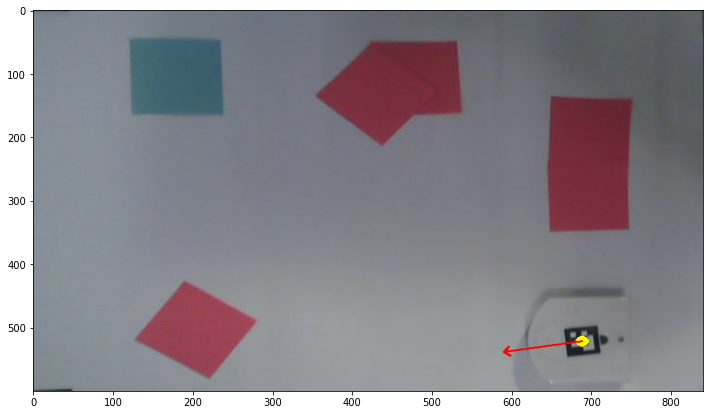

In [7]:
pose = vision.compute_robot_pose(thymio_marker)
draw_pose(calibrated, pose)

## 4. Goal position estimation

The goal is to reach the blue square.
We can filter out the blue colour, detect the contours, and compute the centroid to determine the goal position.

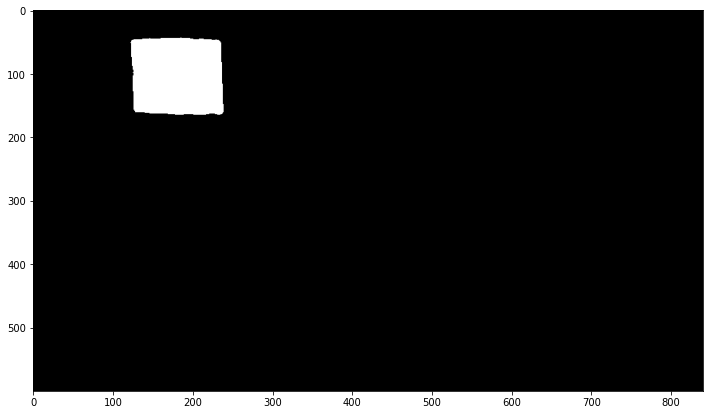

In [8]:
# Detect blue colors
mask = vision.get_color_mask(calibrated, 'blue')
show(mask)

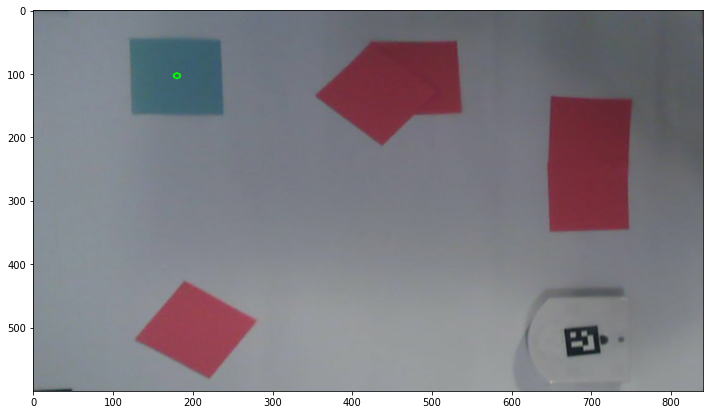

In [9]:
centroids = vision.get_centroids(mask)
draw_centroids(calibrated, centroids)

## 5. Detecting obstacles

Obstacles are red.
We therefore filter the red color, and detect contours on this filtered image.
We use a polygon approximation to considerably reduce the number of points necessary to describe the contour.

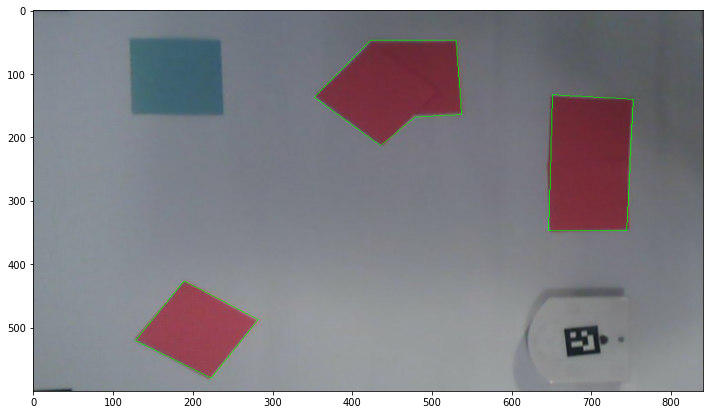

In [10]:
mask = vision.get_color_mask(calibrated, 'red')
obstacles = vision.get_polygon_contours(mask)

result = calibrated.copy()
cv2.drawContours(result, obstacles, -1, (0, 255, 0))
show(result)

If we however plan with these contours, the robot might collide with one of the obstacles as its considered a point robot.
We therefore dilate the obstacles to avoid collisions.

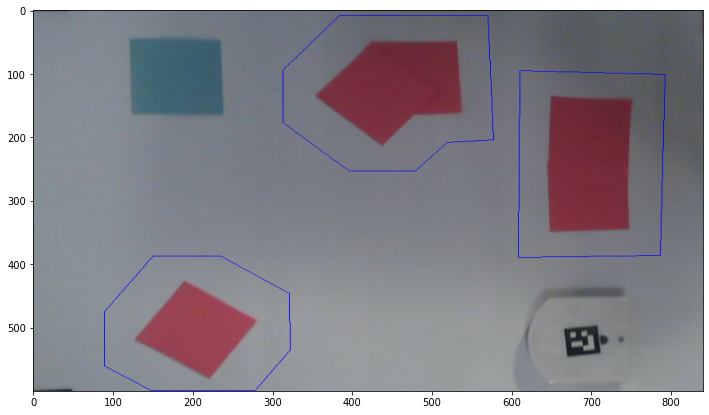

In [11]:
mask = vision.get_color_mask(calibrated, 'red')
obstacles = vision.get_polygon_contours(mask, dilate=80)

result = calibrated.copy()
cv2.drawContours(result, obstacles, -1, (255, 0, 0))
show(result)

## 6. Putting it all together

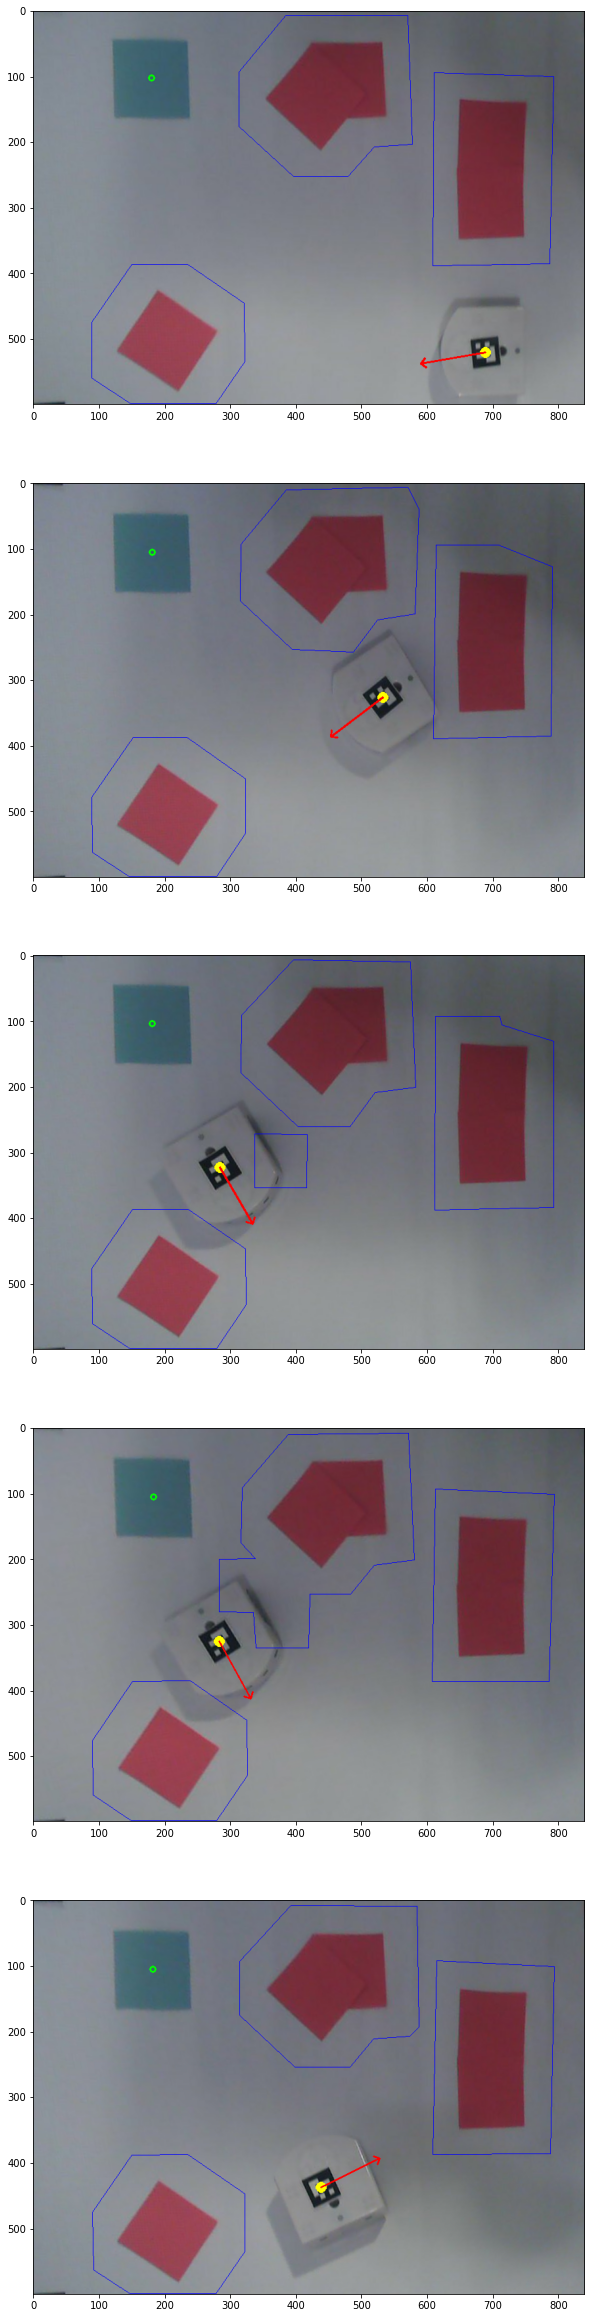

In [12]:
nimages = 5

fig, axes = plt.subplots(nimages, 1, figsize=(18, 42))

for i in range(nimages):
    image_file = f'../data/test-img{i + 1}.jpg'
    img = cv2.imread(image_file)
    ax = axes[i]

    world = vision.analyze_scene(img)

    # Everything is computed on calibrated frame
    result = vision.calibrate(img)
    vision.draw_world(result, world)
    
    rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb)

plt.show()